# 2. Variable Transformation

Now we need to see the dataset is appropriate to be used.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings
import json

warnings.filterwarnings("ignore")
%matplotlib inline

In [172]:
with open("Data/variable_selected.txt", 'r') as f:
    results = json.load(f)

In [173]:
info_cols = results["info_cols"]
interim_cols = results["interim_cols"]

In [174]:
def return_files():
    
    # get all list of csv and excel files
    directory = !pwd
    directory = directory[0]
    data_dir = directory + "/Data"
    files = !ls {data_dir}
    files = [f for f in files if ".zip" not in f]

    # divide by type
    dict_file = ["Data/" + f for f in files if "Dict" in f][0]
    training_files = ["Data/" + f for f in files if "LoanStats" in f]
    target_file = ["Data/" + f for f in files if "listed" in f][0]
    
    return dict_file, training_files, target_file

In [175]:
def read_dict_file(dict_file):
    data_dict = pd.read_excel(dict_file).dropna()
    data_dict.set_index('LoanStatNew', inplace=True)
    data_dict.sort_index(inplace=True)
    print("Reading {}..., {}".format(dict_file, data_dict.shape))
    
    return data_dict

In [176]:
# get file names
dict_file, training_files, target_file = return_files()

## Load Raw Dataset

In [177]:
# get Quarter
def get_quarter(x): 
    if x.month<=3:
        return "Q1"
    elif x.month<=6:
        return "Q2"
    elif x.month<=9:
        return "Q3"
    else:
        return "Q4"

In [178]:
def transform_training_raw_data(training_file, term):

    # read file
    df = pd.read_csv(training_file, sep=",", skiprows=1)
    df = df[df["term"]== term] #" 36 months"

    # change issue_d to datetime type
    df["issue_d"] = [datetime.datetime.strptime(d, "%b-%Y") for d in df["issue_d"] if type(d) is str]

    issue_Qs = df["issue_d"].map(get_quarter)
    issue_Ys = df["issue_d"].map(lambda x: x.year)
    
    if np.max(issue_Ys) < 2014:
        return pd.DataFrame()
    elif np.min(issue_Ys) >= 2017:
        return pd.DataFrame()
    elif np.min(issue_Ys)==2016 and np.min(issue_Qs) in ["Q3","Q4"]:
        return pd.DataFrame()

    # get issuance quarter and year 
    df["issue_Q"] = issue_Qs
    df["issue_y"] = issue_Ys
    
    # remove live loans
    df = df[df["loan_status"]!="Current"]
    
    # defined bad loan status
    bad_loans = ["Charged Off", "Default", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]

    # True/False if status is bad_loans
    df["bad_loan"] = np.where(df["loan_status"].map(lambda x: x in bad_loans), True, False)

    # change last_pymt_d to maximum date if it is NAN 
    ind = df["last_pymnt_d"].isna() 
    dates = df["issue_d"][ind] + datetime.timedelta(36*30)
    dates = dates.map(lambda x: x.strftime("%b-%Y"))
    df["last_pymnt_d"][ind] = dates

    return df

In [179]:
def get_training_dataset(training_files, term, target_cols, other_cols, verbose = True):
    
    dataset = pd.DataFrame()
    
    for file_name in training_files:
        
        if verbose: print("Reading.. ", file_name)
        df = transform_training_raw_data(file_name, term = " 36 months")
        
        if df.shape == (0,0):
            if verbose: print("..Out of period")
            continue
        
        if verbose: print("..Appending")
        if dataset.shape==(0,0):
            dataset = df
        else:
            dataset = dataset.append(df)
    
    cols = target_cols + other_cols
    dataset = dataset[cols]
    
    return dataset

In [180]:
# load raw dataset
term = " 36 months"
df_orig = get_training_dataset(training_files, term, interim_cols, info_cols, verbose=False)

In [181]:
df_orig.shape

(569928, 85)

In [182]:
# make a copy of it
df = df_orig.copy()

Many variables are added during Q4 2015, and therefore, all data points of those variables are missing during the period before Q4 2015. We will keep those variables rather than discarding, since XGBoost model can handle missing data properly without imputing.

In [183]:
# get NaN counts by each Quarter
group = df.groupby(["issue_y","issue_Q"]).agg("count")
total = group["bad_loan"]
group = group[interim_cols]
group = group.apply(lambda x: total-x, axis=0)

In [184]:
total_nan = group.sum()
total_nan = total_nan.sort_values()
old_cols = total_nan[total_nan<=420505].index.values
new_cols = total_nan[total_nan>420505].index.values

In [185]:
print(len(old_cols))
print(len(new_cols))

63
15


So we have 65 old variables, and 15 new variables which are added during Q4 2015. So we need to decide what to do for those 15 variables. Also, note there are variables counting the numbre of months from some events. It also has many missing variables, so we need to think about what to do with those.

In [186]:
group[old_cols]

loan_amnt  delinq_amnt  mo_sin_old_rev_tl_op  \
issue_y issue_Q                                                 
2014    Q1               0            0                     0   
        Q2               0            0                     0   
        Q3               0            0                     0   
        Q4               0            0                     0   
2015    Q1               0            0                     0   
        Q2               0            0                     0   
        Q3               0            0                     0   
        Q4               0            0                     0   
2016    Q1               0            0                     0   
        Q2               0            0                     0   

                 mo_sin_rcnt_rev_tl_op  mo_sin_rcnt_tl  mort_acc  \
issue_y issue_Q                                                    
2014    Q1                           0               0         0   
        Q2                           0               0         0   
        Q3                           0               0         0   
        Q4                           0               0         0   
2015    Q1                           0               0         0   
        Q2                           0               0         0   
        Q3                           0               0         0   
        Q4                           0               0         0   
2016    Q1                           0               0         0   
        Q2                           0               0         0   

                 num_accts_ever_120_pd  num_actv_bc_tl  num_actv_rev_tl  \
issue_y issue_Q                                                           
2014    Q1                           0               0                0   
        Q2                           0               0                0   
        Q3                           0               0                0   
        Q4                           0               0                0   
2015    Q1                           0               0                0   
        Q2                           0               0                0   
        Q3                           0               0                0   
        Q4                           0               0                0   
2016    Q1                           0               0                0   
        Q2                           0               0                0   

                 num_bc_sats            ...             percent_bc_gt_75  \
issue_y issue_Q                         ...                                
2014    Q1                 0            ...                          322   
        Q2                 0            ...                          431   
        Q3                 0            ...                          422   
        Q4                 0            ...                          683   
2015    Q1                 0            ...                          614   
        Q2                 0            ...                          683   
        Q3                 0            ...                          772   
        Q4                 0            ...                         1018   
2016    Q1                 0            ...                          716   
        Q2                 0            ...                          608   

                 bc_util  mo_sin_old_il_acct  num_tl_120dpd_2m  emp_length  \
issue_y issue_Q                                                              
2014    Q1           327                1295              1778        2201   
        Q2           415                1390              1997        2125   
        Q3           454                1300              1400        2106   
        Q4           692                1946              1286        3214   
2015    Q1           632                2135              1741        3715   
        Q2           685                2296              2

In [187]:
group[new_cols]

open_acc_6m  open_rv_12m  open_rv_24m  max_bal_bc  \
issue_y issue_Q                                                      
2014    Q1             34074        34074        34074       34074   
        Q2             37881        37881        37881       37881   
        Q3             40595        40595        40595       40595   
        Q4             50020        50020        50020       50020   
2015    Q1             56568        56568        56568       56568   
        Q2             64222        64222        64222       64222   
        Q3             73559        73559        73559       73559   
        Q4             73786        73786        73786       73786   
2016    Q1                42           42           42          42   
        Q2                 0            0            0           0   

                 open_il_24m  total_bal_il  total_cu_tl  inq_last_12m  \
issue_y issue_Q                                                         
2014    Q1             34074         34074        34074         34074   
        Q2             37881         37881        37881         37881   
        Q3             40595         40595        40595         40595   
        Q4             50020         50020        50020         50020   
2015    Q1             56568         56568        56568         56568   
        Q2             64222         64222        64222         64222   
        Q3             73559         73559        73559         73559   
        Q4             73786         73786        73786         73786   
2016    Q1                42            42           42            42   
        Q2                 0             0            0             0   

                 open_il_12m  open_act_il  inq_fi  all_util  \
issue_y issue_Q                                               
2014    Q1             34074        34074   34074     34074   
        Q2             37881        37881   37881     37881   
        Q3             40595        40595   40595     40595   
        Q4             50020        50020   50020     50020   
2015    Q1             56568        56568   56568     56568   
        Q2             64222        64222   64222     64222   
        Q3             73559        73559   73559     73559   
        Q4             73786        73786   73786     73786   
2016    Q1                42           42      42        47   
        Q2                 0            0       0         2   

                 mths_since_rcnt_il  il_util  mths_since_last_record  
issue_y issue_Q                                                       
2014    Q1                    34074    34074                   27135  
        Q2                    37881    37881                   30407  
        Q3                    40595    40595                   33400  
        Q4                    50020    50020                   40850  
2015    Q1                    56568    56568                   46108  
        Q2                    64222    64222                   52085  
        Q3                    73559    73559                   59744  
        Q4                    74250    75854                   72262  
2016    Q1                     2312    10622                   61677  
        Q2                     1389     6632                   38509

## Old Columns available from Q1 2014

In [188]:
def temp_transform(df, trans_map):
    
    for col, method in trans_map.items(): 
        if method == "log":
            df[col] = np.log(df[col])
        elif method == "1+log":
            df[col] = np.log(1+df[col])
        elif method == "sqrt":
            df[col] = np.sqrt(df[col])
    
    return df         

In [189]:
def temp_cut(df, cut_map):
    for col, cut in cut_map.items():   
        if not np.isnan(cut):
            df[col][df[col]>=cut] = cut
    return df        

In [190]:
def temp_fill(df, fill_map):
    for col, fill in fill_map.items():
        if not np.isnan(fill):
            df[col].fillna(fill, inplace=True)
    return df

In [191]:
def show_summary_stat(summary, df, i, j, glossary, plot_only=False):
    
    part = summary.iloc[:,i:j]
    if not plot_only: display(part)
    
    cols = 3
    rows = np.ceil((j-i)/cols)
    
    fig = plt.figure(figsize=(12,12))
    n = 1
    for col in part.columns.values:
        
        if not plot_only: 
            try:
                print(col, ": ", glossary.loc[col].values[0])
            except:
                print(col, ": ", "no info available")

        ax = fig.add_subplot(rows, cols, n)
        ax.hist(df[col])
        ax.set_title(col)
        n += 1
    
    fig.show()

In [192]:
# get summary
summary = df[old_cols].describe()

# add missing value counts
total = df.shape[0]
row = summary.apply(lambda x: total-x["count"], axis=0)
row = pd.Series(row, name="Nan")

summary = summary.append(row)

Before we jump on, note that there are 11 variabes with special format, which cannot be "Described". We need to take a separate look for these.

In [193]:
# need to check separately these guys
left_cols = [c for c in old_cols if c not in summary.columns.values]
display(df[left_cols].head())
print(len(left_cols))

,earliest_cr_line,application_type,int_rate,sub_grade,home_ownership,addr_state,purpose,revol_util,emp_length
2,Oct-2008,Individual,7.39%,A4,MORTGAGE,FL,debt_consolidation,23.6%,3 years
3,Oct-1993,Individual,17.27%,D2,RENT,WI,credit_card,31.2%,10+ years
8,Dec-2004,Individual,13.67%,C3,RENT,NJ,small_business,49.3%,10+ years
9,Dec-2012,Individual,16.29%,D1,RENT,NY,debt_consolidation,36.4%,3 years
10,May-2005,Individual,10.75%,B4,RENT,TX,debt_consolidation,75.3%,8 years


9


In [194]:
glossary = read_dict_file(dict_file)

Reading Data/LCDataDictionary.xlsx..., (151, 1)


Let's prepare the container to record our choice!

In [195]:
transform_map = {col: np.nan for col in interim_cols}
cut_map = {col: np.nan for col in interim_cols}
fill_map = {col: np.nan for col in interim_cols}

,loan_amnt,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl
count,569928.000000,569928.000000,569928.000000,569928.000000,569928.000000,569928.000000,569928.000000,569928.000000,569928.000000
mean,12852.713764,16.253551,182.854531,12.985303,7.941817,1.597146,0.540888,3.620006,5.669048
std,8109.949086,830.889618,96.526872,16.499337,8.996952,1.984972,1.348477,2.227983,3.295507
min,1000.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6825.000000,0.000000,116.000000,4.000000,3.000000,0.000000,0.000000,2.000000,3.000000
50%,10000.000000,0.000000,165.000000,8.000000,5.000000,1.000000,0.000000,3.000000,5.000000
75%,17200.000000,0.000000,233.000000,16.000000,10.000000,3.000000,0.000000,5.000000,7.000000
max,40000.000000,130778.000000,851.000000,372.000000,289.000000,51.000000,35.000000,35.000000,52.000000
Nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


loan_amnt :  The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
delinq_amnt :  The past-due amount owed for the accounts on which the borrower is now delinquent.
mo_sin_old_rev_tl_op :  Months since oldest revolving account opened
mo_sin_rcnt_rev_tl_op :  Months since most recent revolving account opened
mo_sin_rcnt_tl :  Months since most recent account opened
mort_acc :  Number of mortgage accounts.
num_accts_ever_120_pd :  Number of accounts ever 120 or more days past due
num_actv_bc_tl :  Number of currently active bankcard accounts
num_actv_rev_tl :  Number of currently active revolving trades


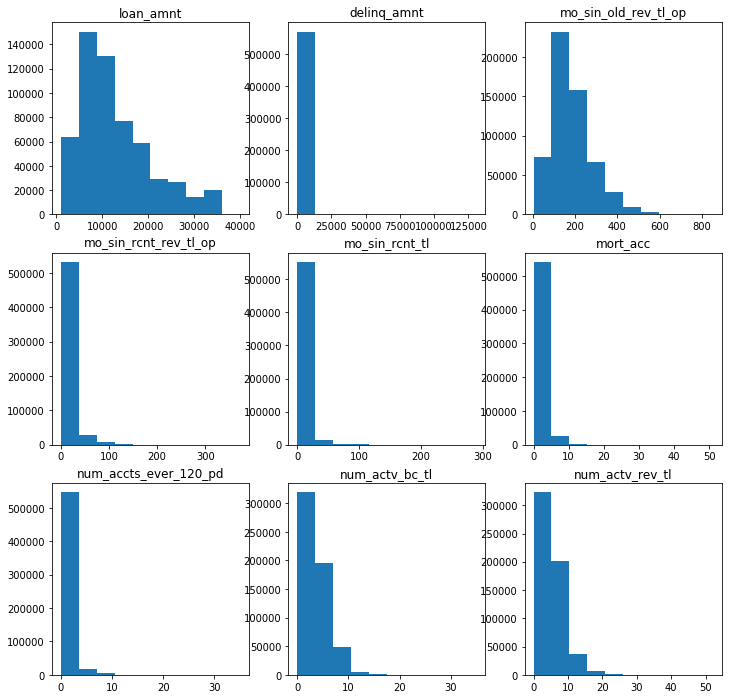

In [196]:
# firs 9 variables
show_summary_stat(summary,df,0,9,glossary)

In [197]:
# these are the record to apply chosen transformation
transform_map["loan_amnt"] = "log"
transform_map["total_bal_ex_mort"] = "1+log"
transform_map["tot_hi_cred_lim"] = "1+log"
transform_map["pct_tl_nvr_dlq"] = "1+log"
transform_map["total_rev_hi_lim"] = "1+log"

In [198]:
# these are the record to apply chosen cut
cut_map["pub_rec_bankruptcies"] = 3
cut_map["num_tl_op_past_12m"] = 10
cut_map["num_tl_90g_dpd_24m"] = 4
cut_map["num_tl_30dpd"] = 2

,num_bc_sats,num_bc_tl,num_il_tl,chargeoff_within_12_mths,num_op_rev_tl,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m
count,569928.000000,569928.000000,569928.000000,569928.000000,569928.000000,569928.000000,569928.000000,569928.000000,569928.000000
mean,4.668732,8.060997,8.310613,0.010598,8.222588,11.535734,0.004022,0.098881,2.161201
std,2.944387,4.817351,7.368468,0.119260,4.531839,5.477026,0.067993,0.533616,1.825128
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,5.000000,3.000000,0.000000,5.000000,8.000000,0.000000,0.000000,1.000000
50%,4.000000,7.000000,6.000000,0.000000,7.000000,11.000000,0.000000,0.000000,2.000000
75%,6.000000,10.000000,11.000000,0.000000,10.000000,14.000000,0.000000,0.000000,3.000000
max,57.000000,70.000000,159.000000,10.000000,73.000000,84.000000,4.000000,30.000000,32.000000
Nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


num_bc_sats :  Number of satisfactory bankcard accounts
num_bc_tl :  Number of bankcard accounts
num_il_tl :  Number of installment accounts
chargeoff_within_12_mths :  Number of charge-offs within 12 months
num_op_rev_tl :  Number of open revolving accounts
num_sats :  Number of satisfactory accounts
num_tl_30dpd :  Number of accounts currently 30 days past due (updated in past 2 months)
num_tl_90g_dpd_24m :  Number of accounts 90 or more days past due in last 24 months
num_tl_op_past_12m :  Number of accounts opened in past 12 months


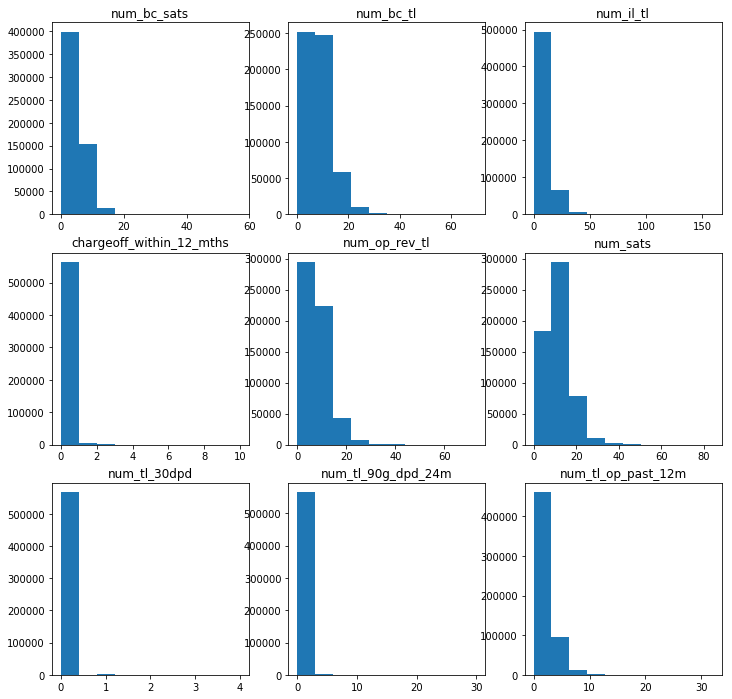

In [199]:
# next 9 variables
show_summary_stat(summary,df,9,18,glossary)

In [200]:
# these are the record to apply chosen transformation
transform_map["delinq_amnt"] = "1+log"
transform_map["mo_sin_old_rev_tl_op"] = "log"
transform_map["mo_sin_rcnt_rev_tl_op"] = "1+log"

transform_map["mo_sin_rcnt_tl"] = "1+log"
transform_map["total_rev_hi_lim"] = "1+log"

In [201]:
# these are the record to apply chosen cut
cut_map["num_sats"] = 42
cut_map["acc_open_past_24mths"] = 20
cut_map["chargeoff_within_12_mths"] = 4
cut_map["mort_acc"] = 10
cut_map["num_accts_ever_120_pd"] = 10

,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,num_rev_tl_bal_gt_0,total_rev_hi_lim
count,569928.000000,569928.000000,569928.000000,5.699280e+05,5.699280e+05,5.699280e+05,5.699280e+05,569928.000000,5.699280e+05
mean,93.750903,0.144104,0.066558,1.624586e+05,4.784767e+04,2.062217e+04,4.029465e+04,5.615369,3.154726e+04
std,9.038795,0.397923,0.454242,1.770829e+05,4.733082e+04,2.155111e+04,4.257967e+04,3.210093,3.844365e+04
min,7.100000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,90.600000,0.000000,0.000000,4.480675e+04,1.964400e+04,7.000000e+03,1.350000e+04,3.000000,1.290000e+04
50%,97.300000,0.000000,0.000000,9.623300e+04,3.545200e+04,1.380000e+04,3.000000e+04,5.000000,2.240000e+04
75%,100.000000,0.000000,0.000000,2.325382e+05,5.997400e+04,2.660000e+04,5.394800e+04,7.000000,3.880000e+04
max,100.000000,12.000000,85.000000,9.999999e+06,2.921551e+06,1.105500e+06,2.101913e+06,45.000000,9.999999e+06
Nan,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00


pct_tl_nvr_dlq :  Percent of trades never delinquent
pub_rec_bankruptcies :  Number of public record bankruptcies
tax_liens :  Number of tax liens
tot_hi_cred_lim :  Total high credit/credit limit
total_bal_ex_mort :  Total credit balance excluding mortgage
total_bc_limit :  Total bankcard high credit/credit limit
total_il_high_credit_limit :  Total installment high credit/credit limit
num_rev_tl_bal_gt_0 :  Number of revolving trades with balance >0
total_rev_hi_lim :  no info available


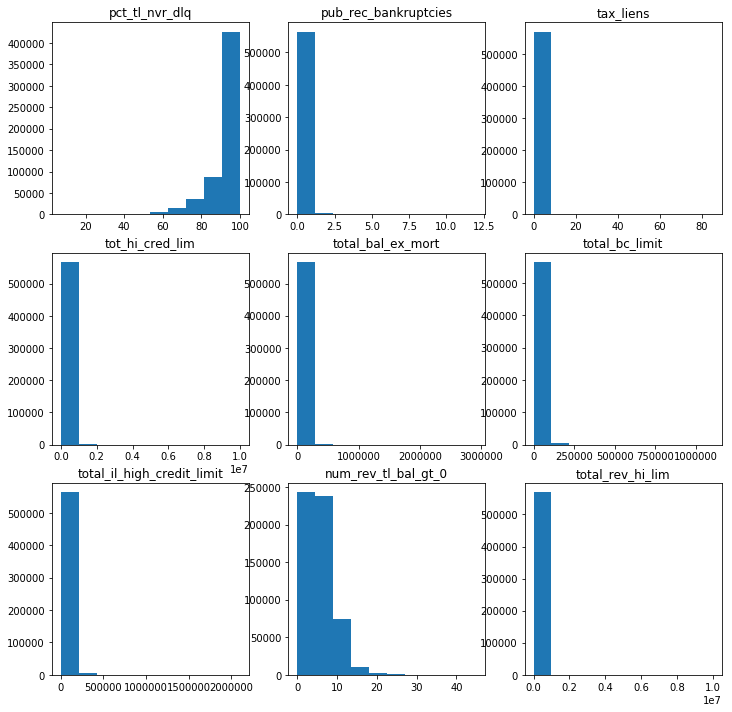

In [202]:
# next 9 variables
show_summary_stat(summary,df,18,27,glossary)

In [203]:
# these are the record to apply chosen transformation
transform_map["total_bc_limit"] = "1+log"
transform_map["total_il_high_credit_limit"] = "1+log"

In [204]:
# these are the record to apply chosen cut
cut_map["num_actv_bc_tl"] = 18
cut_map["num_actv_rev_tl"] = 19
cut_map["num_bc_sats"] = 25
cut_map["num_bc_tl"] = 25
cut_map["num_il_tl"] = 50
cut_map["num_op_rev_tl"] = 34
cut_map["tax_liens"] = 5

,acc_open_past_24mths,collections_12_mths_ex_med,open_acc,pub_rec,revol_bal,total_acc,acc_now_delinq,tot_coll_amt,tot_cur_bal
count,569928.000000,569928.000000,569928.00000,569928.000000,5.699280e+05,569928.000000,569928.000000,5.699280e+05,5.699280e+05
mean,4.601158,0.020313,11.59104,0.248723,1.591767e+04,24.848391,0.006183,2.845001e+02,1.303998e+05
std,3.133124,0.160797,5.49292,0.663598,2.330291e+04,12.013872,0.086681,1.230699e+04,1.542177e+05
min,0.000000,0.000000,0.00000,0.000000,0.000000e+00,2.000000,0.000000,0.000000e+00,0.000000e+00
25%,2.000000,0.000000,8.00000,0.000000,5.665000e+03,16.000000,0.000000,0.000000e+00,2.649600e+04
50%,4.000000,0.000000,11.00000,0.000000,1.047800e+04,23.000000,0.000000,0.000000e+00,6.630200e+04
75%,6.000000,0.000000,14.00000,0.000000,1.884525e+04,32.000000,0.000000,0.000000e+00,1.923755e+05
max,64.000000,20.000000,84.00000,86.000000,2.904836e+06,176.000000,14.000000,9.152545e+06,5.445012e+06
Nan,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00


acc_open_past_24mths :  Number of trades opened in past 24 months.
collections_12_mths_ex_med :  Number of collections in 12 months excluding medical collections
open_acc :  The number of open credit lines in the borrower's credit file.
pub_rec :  Number of derogatory public records
revol_bal :  Total credit revolving balance
total_acc :  The total number of credit lines currently in the borrower's credit file
acc_now_delinq :  The number of accounts on which the borrower is now delinquent.
tot_coll_amt :  Total collection amounts ever owed
tot_cur_bal :  Total current balance of all accounts


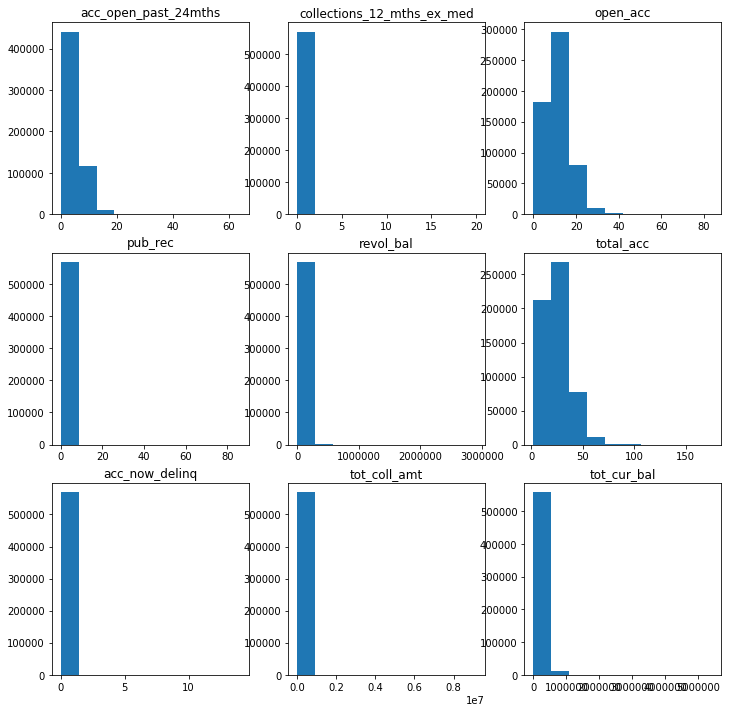

In [205]:
# next 9 variables
show_summary_stat(summary,df,27,36,glossary)

In [206]:
# these are the record to apply chosen transformation
transform_map["tot_cur_bal"] = "1+log"
transform_map["installment"] = "log"
transform_map["annual_inc"] = "1+log"
transform_map["tot_coll_amt"] = "1+log"

In [207]:
# these are the record to apply chosen cut
cut_map["delinq_2yrs"] = 7
cut_map["open_acc"] = 30
cut_map["pub_rec"] = 8
cut_map["acc_now_delinq"] = 2

,delinq_2yrs,inq_last_6mths,installment,annual_inc,num_rev_accts,avg_cur_bal,dti,mths_since_recent_bc,bc_open_to_buy
count,569928.000000,569928.000000,569928.000000,5.699280e+05,569927.000000,569923.000000,569914.000000,564370.000000,564028.000000
mean,0.351476,0.631429,424.016109,7.455311e+04,14.663883,12488.702195,18.296133,23.924316,9546.699368
std,0.932991,0.927559,269.311013,7.179337e+04,8.227562,15843.139310,9.071830,31.120377,14785.989419
min,0.000000,0.000000,14.010000,0.000000e+00,2.000000,0.000000,-1.000000,0.000000,0.000000
25%,0.000000,0.000000,222.570000,4.400000e+04,9.000000,2840.000000,11.790000,6.000000,1314.000000
50%,0.000000,0.000000,344.300000,6.200000e+04,13.000000,6350.000000,17.660000,13.000000,4240.000000
75%,0.000000,1.000000,565.560000,9.000000e+04,19.000000,17013.000000,24.270000,28.000000,11357.000000
max,30.000000,6.000000,1569.110000,9.573072e+06,105.000000,555925.000000,999.000000,639.000000,332178.000000
Nan,0.000000,0.000000,0.000000,0.000000e+00,1.000000,5.000000,14.000000,5558.000000,5900.000000


delinq_2yrs :  The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
inq_last_6mths :  The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
installment :  The monthly payment owed by the borrower if the loan originates.
annual_inc :  The self-reported annual income provided by the borrower during registration.
num_rev_accts :  Number of revolving accounts
avg_cur_bal :  Average current balance of all accounts
dti :  A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
mths_since_recent_bc :  Months since most recent bankcard account opened.
bc_open_to_buy :  Total open to buy on revolving bankcards.


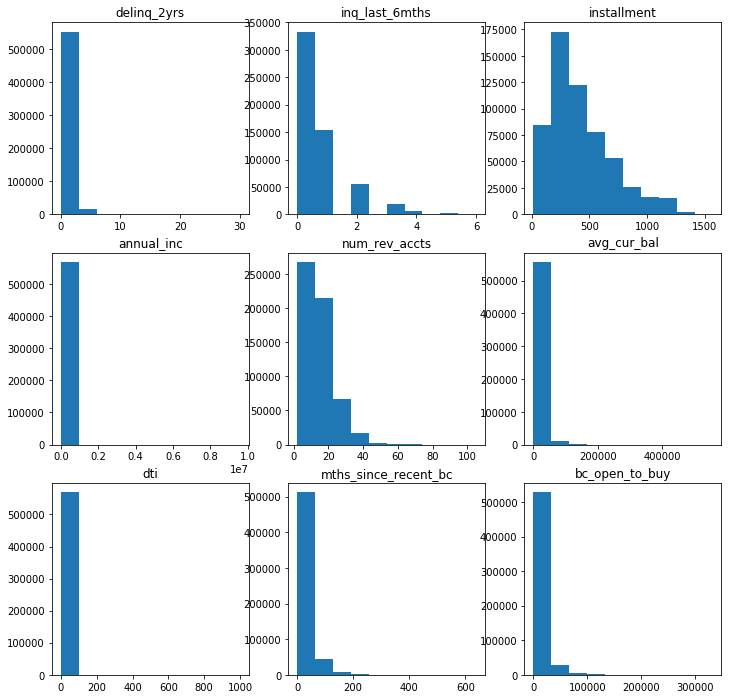

In [208]:
# next 9 variables
show_summary_stat(summary,df,36,45,glossary)

In [209]:
df = df[df["dti"]>=0]

In [210]:
# these are the record to apply chosen transformation
transform_map["revol_bal"] = "1+log"
transform_map["num_rev_accts"] = "log"
transform_map["avg_cur_bal"] = "1+log"
transform_map["dti"] = "1+log"
transform_map["mths_since_recent_bc"] = "1+log"
transform_map["bc_open_to_buy"] = "1+log"

In [211]:
# these are the record to apply chosen cut
cut_map["collections_12_mths_ex_med"] = 3
cut_map["total_acc"] = 57
cut_map["num_rev_tl_bal_gt_0"] = 19

,percent_bc_gt_75,bc_util,mo_sin_old_il_acct,num_tl_120dpd_2m,mths_since_recent_inq,mths_since_last_delinq,mths_since_recent_revol_delinq,mths_since_last_major_derog,mths_since_recent_bc_dlq
count,563659.000000,563635.000000,550374.000000,543191.000000,511273.000000,295348.000000,207631.000000,169420.000000,149423.000000
mean,45.731553,60.660660,125.190587,0.000917,6.826044,33.881641,35.723871,43.434217,39.823508
std,36.014067,27.711977,52.792181,0.032776,5.919217,21.891494,22.535673,21.254856,22.878072
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.500000,39.600000,97.000000,0.000000,2.000000,15.000000,17.000000,26.000000,20.000000
50%,50.000000,63.700000,128.000000,0.000000,5.000000,30.000000,33.000000,43.000000,38.000000
75%,75.000000,85.000000,152.000000,0.000000,10.000000,50.000000,53.000000,61.000000,59.000000
max,100.000000,318.200000,724.000000,6.000000,25.000000,192.000000,197.000000,192.000000,189.000000
Nan,6269.000000,6293.000000,19554.000000,26737.000000,58655.000000,274580.000000,362297.000000,400508.000000,420505.000000


percent_bc_gt_75 :  Percentage of all bankcard accounts > 75% of limit.
bc_util :  Ratio of total current balance to high credit/credit limit for all bankcard accounts.
mo_sin_old_il_acct :  Months since oldest bank installment account opened
num_tl_120dpd_2m :  Number of accounts currently 120 days past due (updated in past 2 months)
mths_since_recent_inq :  Months since most recent inquiry.
mths_since_last_delinq :  The number of months since the borrower's last delinquency.
mths_since_recent_revol_delinq :  Months since most recent revolving delinquency.
mths_since_last_major_derog :  Months since most recent 90-day or worse rating
mths_since_recent_bc_dlq :  Months since most recent bankcard delinquency


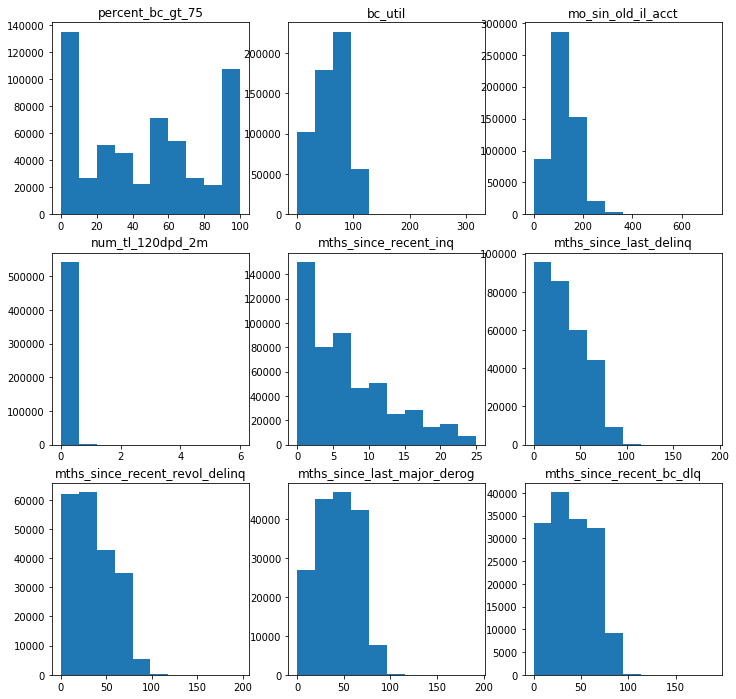

In [212]:
# next 9 variables
show_summary_stat(summary,df,45,54,glossary)

In [213]:
# these are the record to apply chosen transformation
transform_map["bc_util"] = "1+log"
transform_map["mo_sin_old_il_acct"] = "1+log"
transform_map["mo_sin_old_il_acct"] = "1+log"
transform_map["mths_since_recent_inq"] = "1+log"
transform_map["mths_since_last_delinq"] = "1+log"
transform_map["mths_since_recent_revol_delinq"] = "1+log"
transform_map["mths_since_last_major_derog"] = "1+log"
transform_map["mths_since_recent_bc_dlq"] = "1+log"

In [214]:
# these are the record to apply chosen cut
cut_map["num_tl_120dpd_2m"] = 2

In [215]:
# fill map
fill_map["mo_sin_old_il_acct"] = np.max(df["mo_sin_old_il_acct"])
fill_map["mths_since_recent_inq"] = np.max(df["mths_since_recent_inq"])
fill_map["mths_since_last_delinq"] = np.max(df["mths_since_last_delinq"])
fill_map["mths_since_recent_revol_delinq"] = np.max(df["mths_since_recent_revol_delinq"])
fill_map["mths_since_last_major_derog"] = np.max(df["mths_since_last_major_derog"])
fill_map["mths_since_recent_bc_dlq"] = np.max(df["mths_since_recent_bc_dlq"])


## Rest 11 Columns available from Q1 2014

In [216]:
group[left_cols]

earliest_cr_line  application_type  int_rate  sub_grade  \
issue_y issue_Q                                                            
2014    Q1                      0                 0         0          0   
        Q2                      0                 0         0          0   
        Q3                      0                 0         0          0   
        Q4                      0                 0         0          0   
2015    Q1                      0                 0         0          0   
        Q2                      0                 0         0          0   
        Q3                      0                 0         0          0   
        Q4                      0                 0         0          0   
2016    Q1                      0                 0         0          0   
        Q2                      0                 0         0          0   

                 home_ownership  addr_state  purpose  revol_util  emp_length  
issue_y issue_Q                                                               
2014    Q1                    0           0        0          14        2201  
        Q2                    0           0        0          15        2125  
        Q3                    0           0        0          26        2106  
        Q4                    0           0        0          22        3214  
2015    Q1                    0           0        0          26        3715  
        Q2                    0           0        0          22        3806  
        Q3                    0           0        0          40        4983  
        Q4                    0           0        0          38        6457  
2016    Q1                    0           0        0          52        5680  
        Q2                    0           0        0          26        3347

In [217]:
transform_map["earliest_cr_line"] = "log"
transform_map["revol_util"] = "1+log"

In [218]:
# int_rate - change it to double
df["int_rate"] = df["int_rate"].map(lambda x: float(x.split("%")[0])/100) # change interest format

In [219]:
# revol_util - change it to double
ind = (df["revol_util"].isna()==0)
df["revol_util"][ind] = df["revol_util"][ind].map(lambda x: float(x.split("%")[0])/100) # change interest format

In [220]:
# home_ownership - delete ANY
df = df[df["home_ownership"]!="ANY"] # delete any

In [221]:
# purpos - combine to other category
df["purpose"][df["purpose"]=="educational"] = "other" 
df["purpose"][df["purpose"]=="renewable_energy"] = "other" 
df["purpose"][df["purpose"]=="wedding"] = "other" 

In [222]:
# earliest_cr_line - change to days until issue_d and log trans
df["earliest_cr_line"] = df["earliest_cr_line"].map(lambda x: datetime.datetime.strptime(x, "%b-%Y"))
delta = df["issue_d"] - df["earliest_cr_line"]
delta = delta.map(lambda x: x.days)
df["earliest_cr_line"] = delta 

In [223]:
# emp_length
def emp_filter(x):
    if "<" in x:
        x = int(x[2])
    else:
        x = x.split(" ")[0].split("+")[0]
        x = int(x)+1
    
    return(x)

ind = (df["emp_length"].isna()==0)
df["emp_length"][ind] = df["emp_length"][ind].map(emp_filter) # change interest format

In [224]:
# application_type, sub_grade, addr_state - ok

## New Columns available after Q4 2015

For these new variables we will not fill any missin data points, and let the model to handle it.

In [225]:
len(new_cols)

15

In [226]:
# get summary
summary = df[new_cols].describe()

# add missing value counts
total = df.shape[0]
row = summary.apply(lambda x: total-x["count"], axis=0)
row = pd.Series(row, name="Nan")

summary = summary.append(row)

,open_acc_6m,open_rv_12m,open_rv_24m,max_bal_bc,open_il_24m,total_bal_il,total_cu_tl,inq_last_12m,open_il_12m
count,139167.000000,139167.000000,139167.000000,139167.000000,139167.000000,1.391670e+05,139167.000000,139167.000000,139167.000000
mean,1.065504,1.439961,3.037114,5534.412195,1.651117,3.401639e+04,1.513822,2.258574,0.773366
std,1.226732,1.570210,2.681822,5914.114501,1.700393,4.098671e+04,2.738668,2.517873,1.015905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2160.000000,0.000000,8.963000e+03,0.000000,0.000000,0.000000
50%,1.000000,1.000000,2.000000,4073.000000,1.000000,2.287600e+04,0.000000,2.000000,0.000000
75%,2.000000,2.000000,4.000000,7091.000000,2.000000,4.401900e+04,2.000000,3.000000,1.000000
max,18.000000,28.000000,53.000000,776843.000000,51.000000,1.062286e+06,79.000000,40.000000,25.000000
Nan,430744.000000,430744.000000,430744.000000,430744.000000,430744.000000,4.307440e+05,430744.000000,430744.000000,430744.000000


open_acc_6m :  Number of open trades in last 6 months
open_rv_12m :  Number of revolving trades opened in past 12 months
open_rv_24m :  Number of revolving trades opened in past 24 months
max_bal_bc :  Maximum current balance owed on all revolving accounts
open_il_24m :  Number of installment accounts opened in past 24 months
total_bal_il :  Total current balance of all installment accounts
total_cu_tl :  Number of finance trades
inq_last_12m :  Number of credit inquiries in past 12 months
open_il_12m :  Number of installment accounts opened in past 12 months


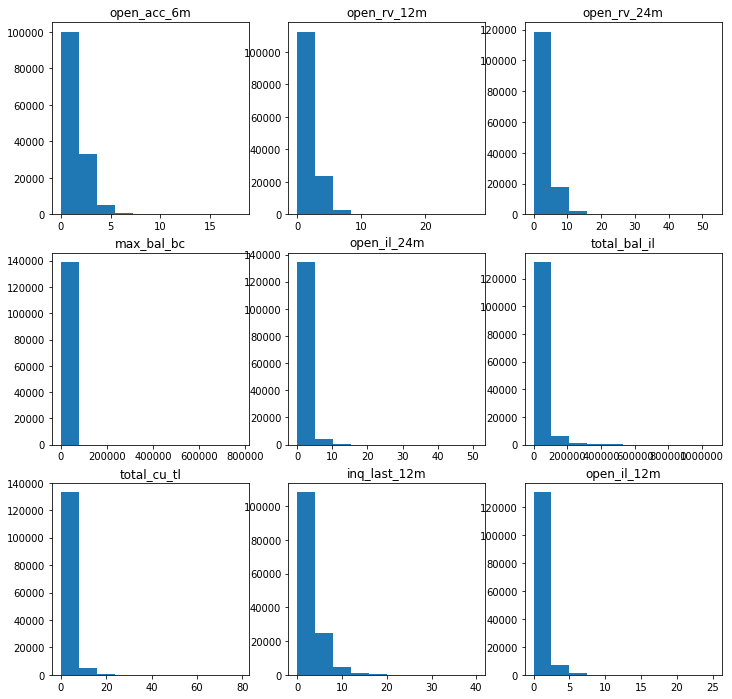

In [227]:
# next 9 variables
show_summary_stat(summary,df,0,9,glossary)

In [228]:
# these are the record to apply chosen transformation
transform_map["max_bal_bc"] = "1+log"

In [229]:
# these are the record to apply chosen cut
cut_map["open_acc_6m"] = 8
cut_map["total_bal_il"] = 8
cut_map["open_rv_12m"] = 7
cut_map["open_rv_24m"] = 11
cut_map["open_il_24m"] = 8
cut_map["open_il_12m"] = 7
cut_map["inq_fi"] = 11
cut_map["open_il_12m"] = 18

,open_act_il,inq_fi,all_util,mths_since_rcnt_il,il_util,mths_since_last_record
count,139167.000000,139167.000000,139160.000000,135045.000000,119890.000000,107749.000000
mean,2.771110,0.980211,59.580684,21.175134,71.507198,67.236921
std,3.029945,1.519807,20.454321,26.864037,23.071909,26.133333
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,46.000000,6.000000,59.000000,50.000000
50%,2.000000,0.000000,61.000000,12.000000,75.000000,67.000000
75%,3.000000,1.000000,74.000000,23.000000,88.000000,84.000000
max,48.000000,28.000000,204.000000,363.000000,558.000000,121.000000
Nan,430744.000000,430744.000000,430751.000000,434866.000000,450021.000000,462162.000000


open_act_il :  Number of currently active installment trades
inq_fi :  Number of personal finance inquiries
all_util :  Balance to credit limit on all trades
mths_since_rcnt_il :  Months since most recent installment accounts opened
il_util :  Ratio of total current balance to high credit/credit limit on all install acct
mths_since_last_record :  The number of months since the last public record.


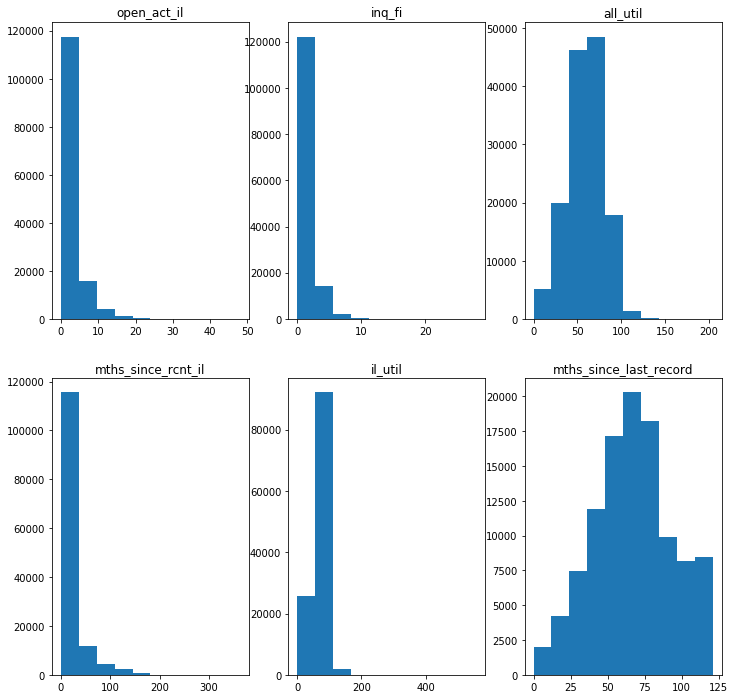

In [230]:
# next 9 variables
show_summary_stat(summary,df,9,15,glossary)

In [231]:
# these are the record to apply chosen transformation
transform_map["all_util"] = "1+log"
transform_map["mths_since_rcnt_il"] = "1+log"
transform_map["il_util"] = "1+log"

In [232]:
# these are the record to apply chosen cut
cut_map["inq_last_12m"] = 11
cut_map["open_act_il"] = 11

## Summary

We need following data filtering first.

In [234]:
with open("Data/variable_selected.txt", 'r') as f:
    results = json.load(f)

In [235]:
info_cols = results["info_cols"]
interim_cols = results["interim_cols"]

In [236]:
# get file names
dict_file, training_files, target_file = return_files()

In [237]:
# load raw dataset
term = " 36 months"
df_orig = get_training_dataset(training_files, term, interim_cols, info_cols, verbose=False)

In [280]:
# make a copy of it
df = df_orig.copy()

In [254]:
# int_rate - change it to double
df["int_rate"] = df["int_rate"].map(lambda x: np.float32(x.split("%")[0])/100) # change interest format
df["int_rate"] = list(map(float, df["int_rate"]))

In [272]:
# revol_util - change it to double
#ind = (df["revol_util"].isna()==0)
df.loc[df["revol_util"].notna(),"revol_util"] = df.loc[df["revol_util"].notna(),"revol_util"].map(lambda x: np.float32(x.split("%")[0])/100) # change ratio format
df["revol_util"] = list(map(float, df["revol_util"]))

In [241]:
# home_ownership - delete ANY
df = df[df["home_ownership"]!="ANY"] # delete any

In [276]:
# purpose - combine to other category
df.loc[df["purpose"]=="educational", "purpose"] = "other" 
df.loc[df["purpose"]=="renewable_energy", "purpose"] = "other" 
df.loc[df["purpose"]=="wedding", "purpose"] = "other" 

In [243]:
# earliest_cr_line - change to days until issue_d and log trans
df["earliest_cr_line"] = df["earliest_cr_line"].map(lambda x: datetime.datetime.strptime(x, "%b-%Y"))
delta = df["issue_d"] - df["earliest_cr_line"]
delta = delta.map(lambda x: x.days)
df["earliest_cr_line"] = delta 

In [244]:
# emp_length
def emp_filter(x):
    if "<" in x:
        x = int(x[2])
    else:
        x = x.split(" ")[0].split("+")[0]
        x = int(x)+1
    
    return(x)

ind = (df["emp_length"].isna()==0)
df["emp_length"][ind] = df["emp_length"][ind].map(emp_filter) # change interest format

In [245]:
# remove dti -1
df = df[df["dti"]>=0]

In [246]:
# fill missing values
df = temp_fill(df, fill_map)

In [247]:
# cut missing values
df = temp_cut(df, cut_map)

In [248]:
# cut missing values
df = temp_transform(df, transform_map)

## Save the results

In [249]:
results = {}
results["transform"] = transform_map
results["cut"] = cut_map
results["fill"] = fill_map

In [250]:
with open("Data/transform_map.txt", 'w') as f:
    json.dump(results, f)

In [251]:
with open("Data/transform_map.txt", 'r') as f:
    results = json.load(f)

In [252]:
transform_map = results["transform"]
cut_map = results["cut"]
fill_map = results["fill"]

transform = pd.DataFrame({"transform" : transform_map, "cut" : cut_map, "fill" : fill_map})
transform

,transform,cut,fill
acc_now_delinq,NaN,2.0,NaN
acc_open_past_24mths,NaN,20.0,NaN
addr_state,NaN,NaN,NaN
all_util,1+log,NaN,NaN
annual_inc,1+log,NaN,NaN
application_type,NaN,NaN,NaN
avg_cur_bal,1+log,NaN,NaN
bc_open_to_buy,1+log,NaN,NaN
bc_util,1+log,NaN,NaN
chargeoff_within_12_mths,NaN,4.0,NaN
